In [26]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

In [50]:
date1= lambda dates: pd.datetime.strptime(dates, '%Y-%m')

df = pd.read_csv("AirPassengers.csv", 
            parse_dates=["Month"],
            index_col="Month",
            date_parser=date1)

In [79]:
df.columns

Index(['#Passengers'], dtype='object')

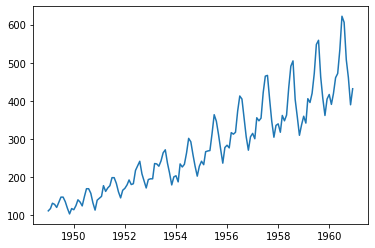

In [51]:
plt.plot(df)

In [104]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(df):
    
    # Determing rolling statistics
    rolmean = df.rolling(12).mean()
    rolstd = df.rolling(12).std()

    # Plot rolling statistics:
    orig = plt.plot(df, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(df['#Passengers'])
    dfoutput = pd.Series(dftest[:4], index=[
        'Test Statistic',
        'p-value',
        '#Lags Used',
        'Number of Observations Used'])
    
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

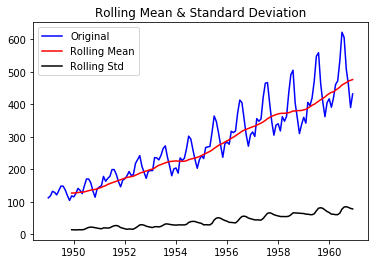

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [105]:
test_stationarity(df)

In [114]:
import numpy as np

df_log = np.log(df)
rolmean = df_log.rolling(12).mean()

new_df = df_log - rolmean

In [118]:
new_df = new_df.dropna()

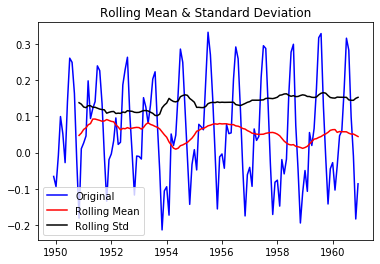

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [136]:
test_stationarity(new_df)

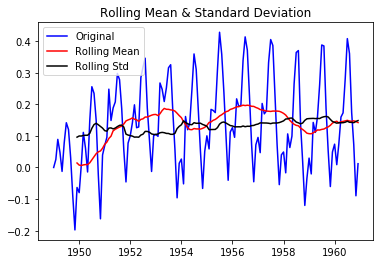

Results of Dickey-Fuller Test:
Test Statistic                  -3.601262
p-value                          0.005737
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [134]:
ewma = df_log.ewm(halflife=12).mean()
new_df2 = df_log - ewma
new_df2 = new_df2.dropna()

test_stationarity(new_df2)

In [140]:
df_log_diff = df_log - df_log.shift()

In [142]:
df_log_diff = df_log_diff.dropna()

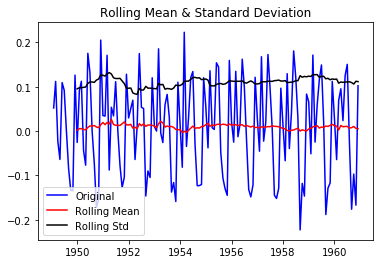

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [143]:
test_stationarity(df_log_diff)

In [150]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

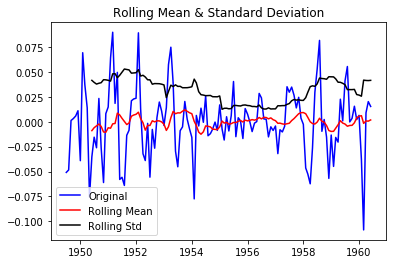

Results of Dickey-Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


In [151]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

In [156]:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(df_log_diff, nlags=20)
lag_pacf = pacf(df_log_diff, nlags=20, method='ols')

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


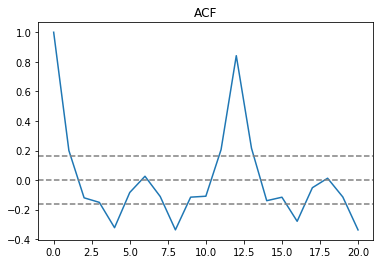

In [178]:
plt.plot(lag_acf)
plt.title("ACF")
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='gray')

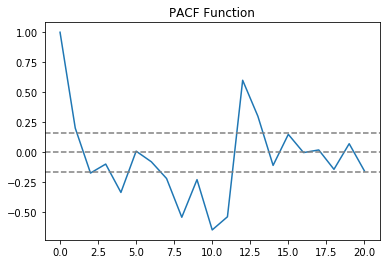

In [179]:
plt.plot(lag_pacf)
plt.title("PACF Function")
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(df_log_diff)),linestyle='--',color='gray')

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


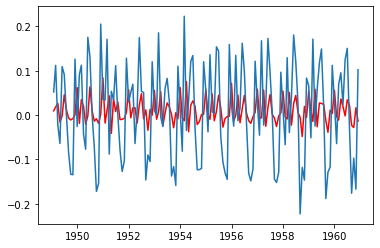

In [163]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(df_log, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(results_AR.fittedvalues, color='red')
plt.plot(df_log_diff)

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


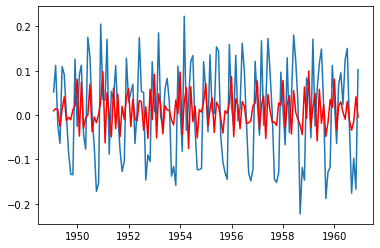

In [165]:
model = ARIMA(df_log, order=(0, 1, 2))  
results_MA = model.fit(disp=-1)  
plt.plot(df_log_diff)
plt.plot(results_MA.fittedvalues, color='red')

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


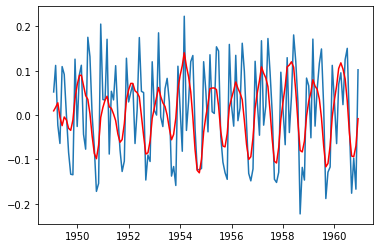

In [166]:
model = ARIMA(df_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(df_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')

In [167]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023889
dtype: float64

In [171]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

Month
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
dtype: float64

In [176]:
predictions_ARIMA_log = pd.Series(df_log.iloc[0], index=df_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

Month
1949-01-01         NaN
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
dtype: float64

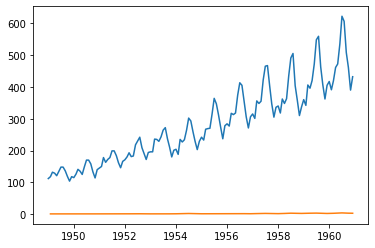

In [170]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(df)
plt.plot(predictions_ARIMA)

In [181]:
from pandas.plotting import autocorrelation_plot

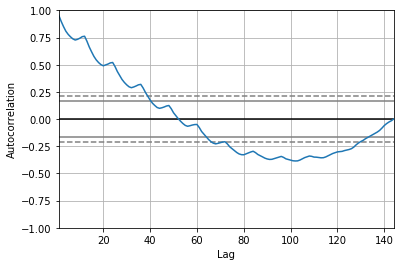

In [193]:
autocorrelation_plot(df_log)

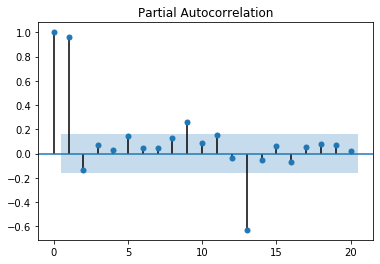

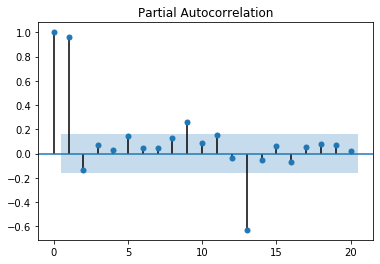

In [194]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

plot_pacf(df_log, lags=20)

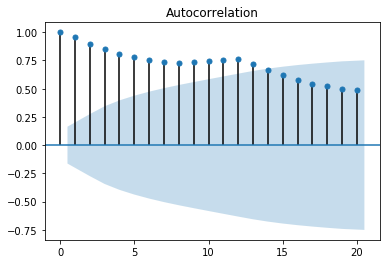

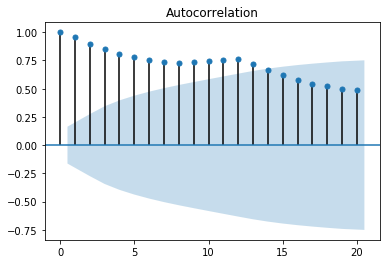

In [195]:
plot_acf(df_log, lags=20)

In [201]:
df_log

,#Passengers
Month,
1949-01-01,4.718499
1949-02-01,4.770685
1949-03-01,4.882802
1949-04-01,4.859812
1949-05-01,4.795791
...,...
1960-08-01,6.406880
1960-09-01,6.230481
1960-10-01,6.133398
